# Generating Hot Spots

To simulate a forest fire, a perlin noise map is used to generate the lattitude and longitude coordinates of hot spots. 
By modifying the characteristics of the noise map and applying a cutoff value, a **natural** looking fire heat map can be generated. 
This heat map is then used to generate a list of hot spot coordinates.

### Functions

```python
def Generate_Noise_Map(size: int = 100, seed: int = 0, octaves: int = 3, persistence: float = 0.75, lacunarity: float = 2.0) -> np.ndarray:
    """
    Generate a noise map using Perlin noise.

    Parameters
    ----------
    size : int, optional
        The size of the noise map, which will be a square matrix of dimensions (size x size). Defaults to 100.
    seed : int, optional
        The seed for the noise generation, used to initialize the random number generator. Defaults to 0.
    octaves : int, optional
        The number of levels of detail in the noise. Higher values result in more detailed noise. Defaults to 3.
    persistence : float, optional
        The amplitude of each octave in the noise. This affects the roughness of the noise. Defaults to 0.75.
    lacunarity : float, optional
        The frequency of each octave in the noise. This affects the detail frequency. Defaults to 2.0.

    Returns
    -------
    np.ndarray
        A normalized noise matrix of shape (size, size), with values ranging from 0 to 1.
    """

def Apply_Cutoff(noise: np.ndarray, cutoff: float) -> np.ndarray:
    """
    Apply a cutoff threshold to a noise matrix.

    Parameters
    ----------
    noise : np.ndarray
        The noise matrix to apply the cutoff to.
    cutoff : float
        The cutoff value. Elements of the noise matrix below this value will be set to 0.0.

    Returns
    -------
    np.ndarray
        The noise matrix with values below the cutoff set to 0.0.
    """
```

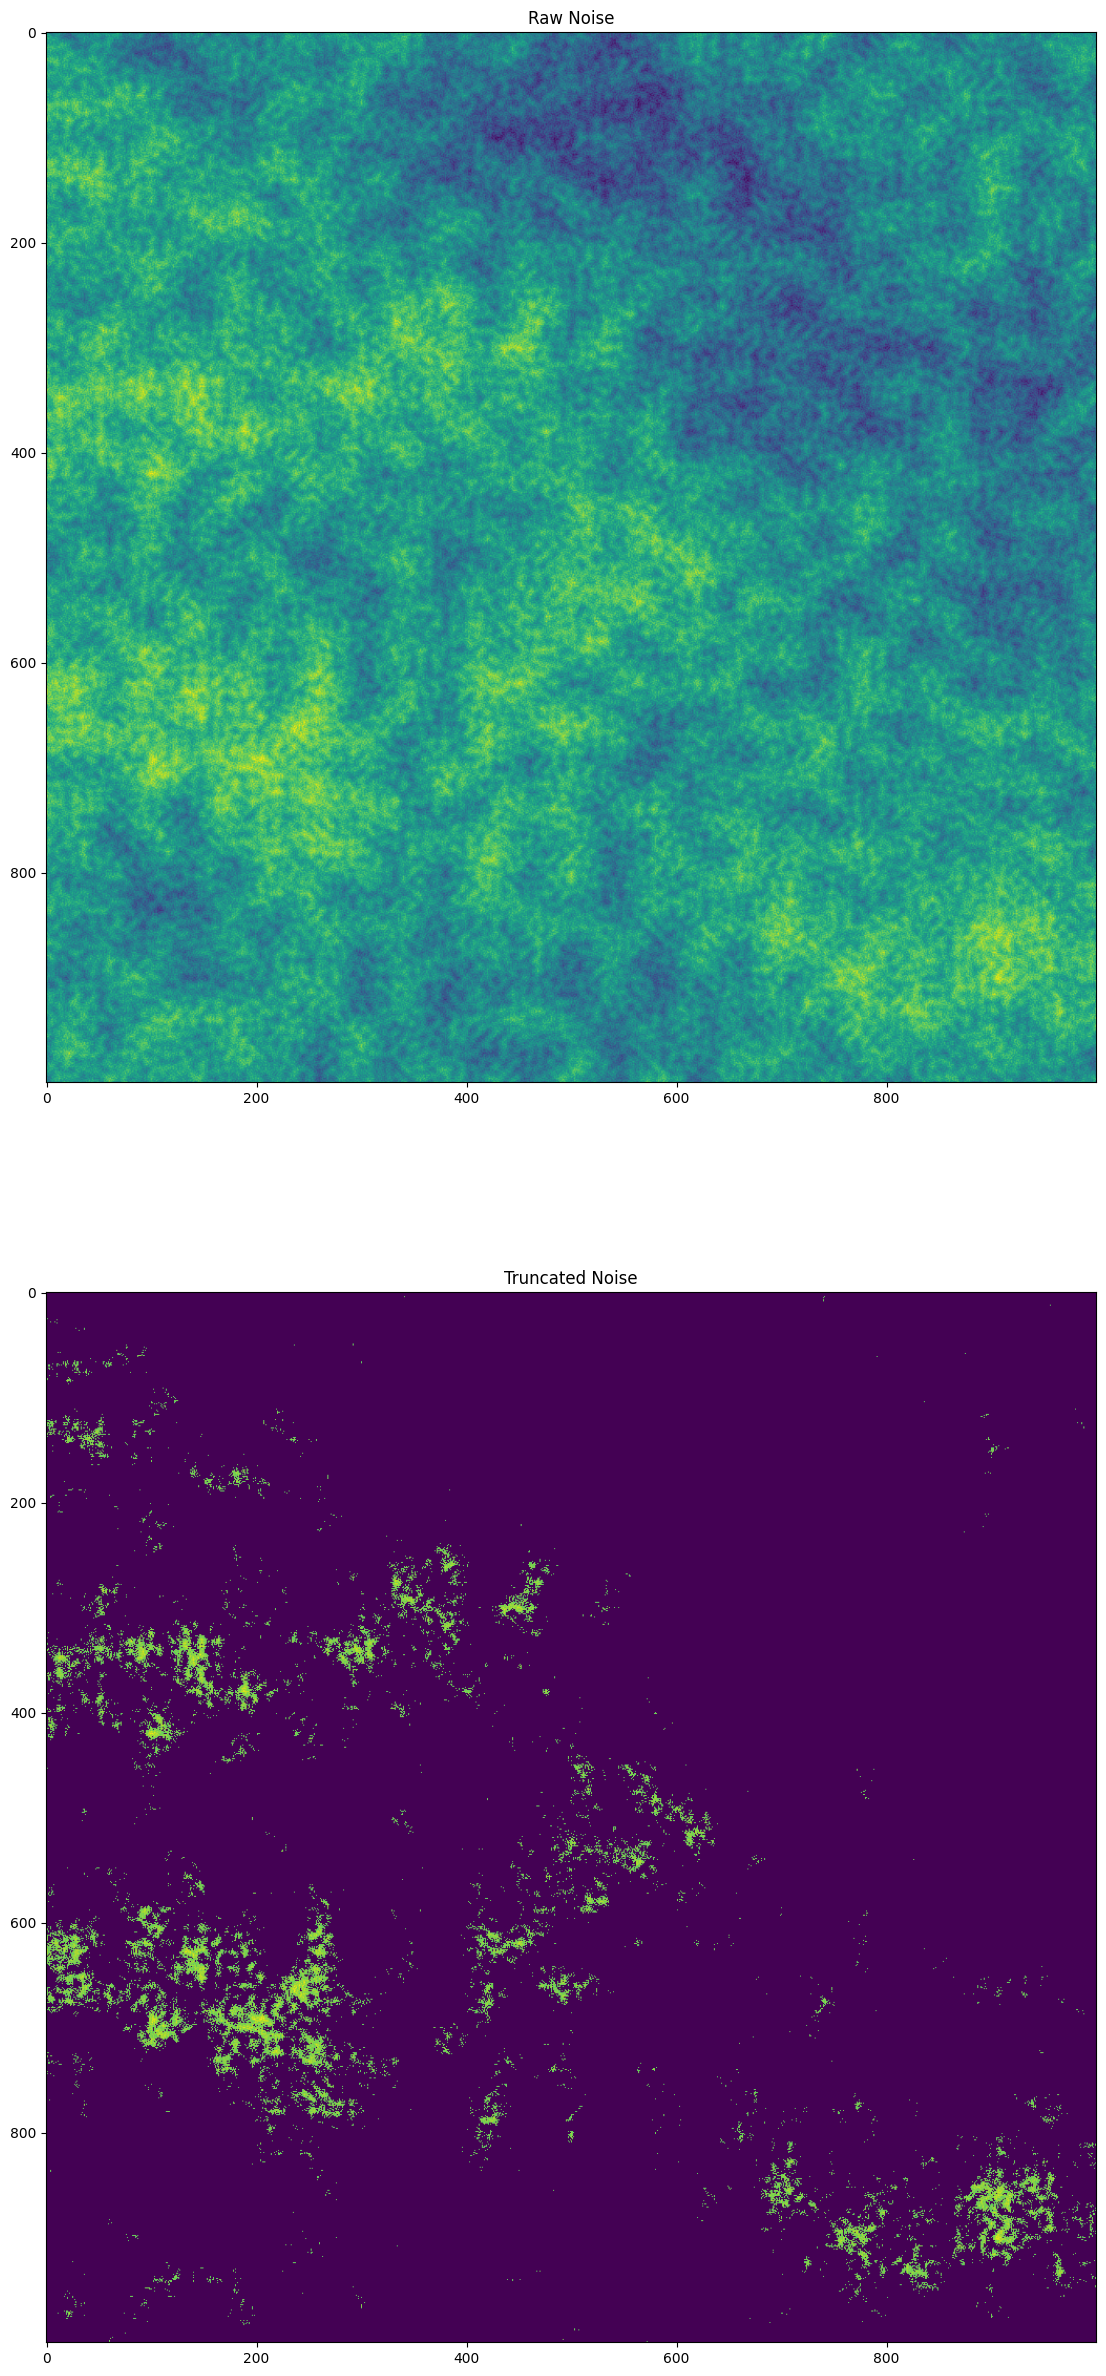

In [1]:
from numpy import ndarray
from matplotlib import pyplot as plt
from Source.Fire_Map import Generate_Noise_Map, Apply_Cutoff

# Create noise map
noiseMap: ndarray = Generate_Noise_Map(
    size=1000, # Determines how many lat/long coordinates will be generated, n^2
    seed=25,
    octaves=5,
    persistence=0.85,
    lacunarity=5
)

# Apply cut off
noiseMapTruncated: ndarray = Apply_Cutoff(noiseMap, 0.75)

# Create a matplot figure
figure, axis = plt.subplots(2, 1, figsize=(30, 30))
axis[0].imshow(noiseMap)
axis[1].imshow(noiseMapTruncated)
axis[0].set_title("Raw Noise")
axis[1].set_title("Truncated Noise")
plt.show()

## Adjusting Axis Ranges

The coordinates generated from the noise map are scaled and shifted to fit within the latitude and longitude ranges of the simulated testing area.
Latitude ranges from 5 to 11 degrees and longitude ranges from -78 to -73 degrees.

![Testing Area](./Images/Testing_Area.png)

### Functions

```python
def Convert_to_Coordinates(noise: np.ndarray) -> list[tuple[int, int]]:
    """
    Converts a noise matrix to a list of coordinate pairs.

    Parameters
    ----------
    noise : np.ndarray
        The noise matrix to convert.

    Returns
    -------
    list[tuple[int, int]]
        A list of coordinate pairs.
    """

def Adjust_Axis_Ranges(
    coordinates: list[tuple[int, int]], longitudeRange: tuple[float, float], latitudeRange: tuple[float, float], xLength: int, yLength: int) -> list[tuple[int, int]]:
    """
    Adjusts a list of coordinates to fit within a specific longitude and latitude range.

    Parameters
    ----------
    coordinates : list[tuple[int, int]]
        The list of coordinates to adjust.
    longitudeRange : tuple[float, float]
        The range of the longitude axis.
    latitudeRange : tuple[float, float]
        The range of the latitude axis.
    xLength : int
        The length of the x-axis.
    yLength : int
        The length of the y-axis.

    Returns
    -------
    list[tuple[int, int]]
        The adjusted list of coordinates.
    """
```

33,071 coordinates generated


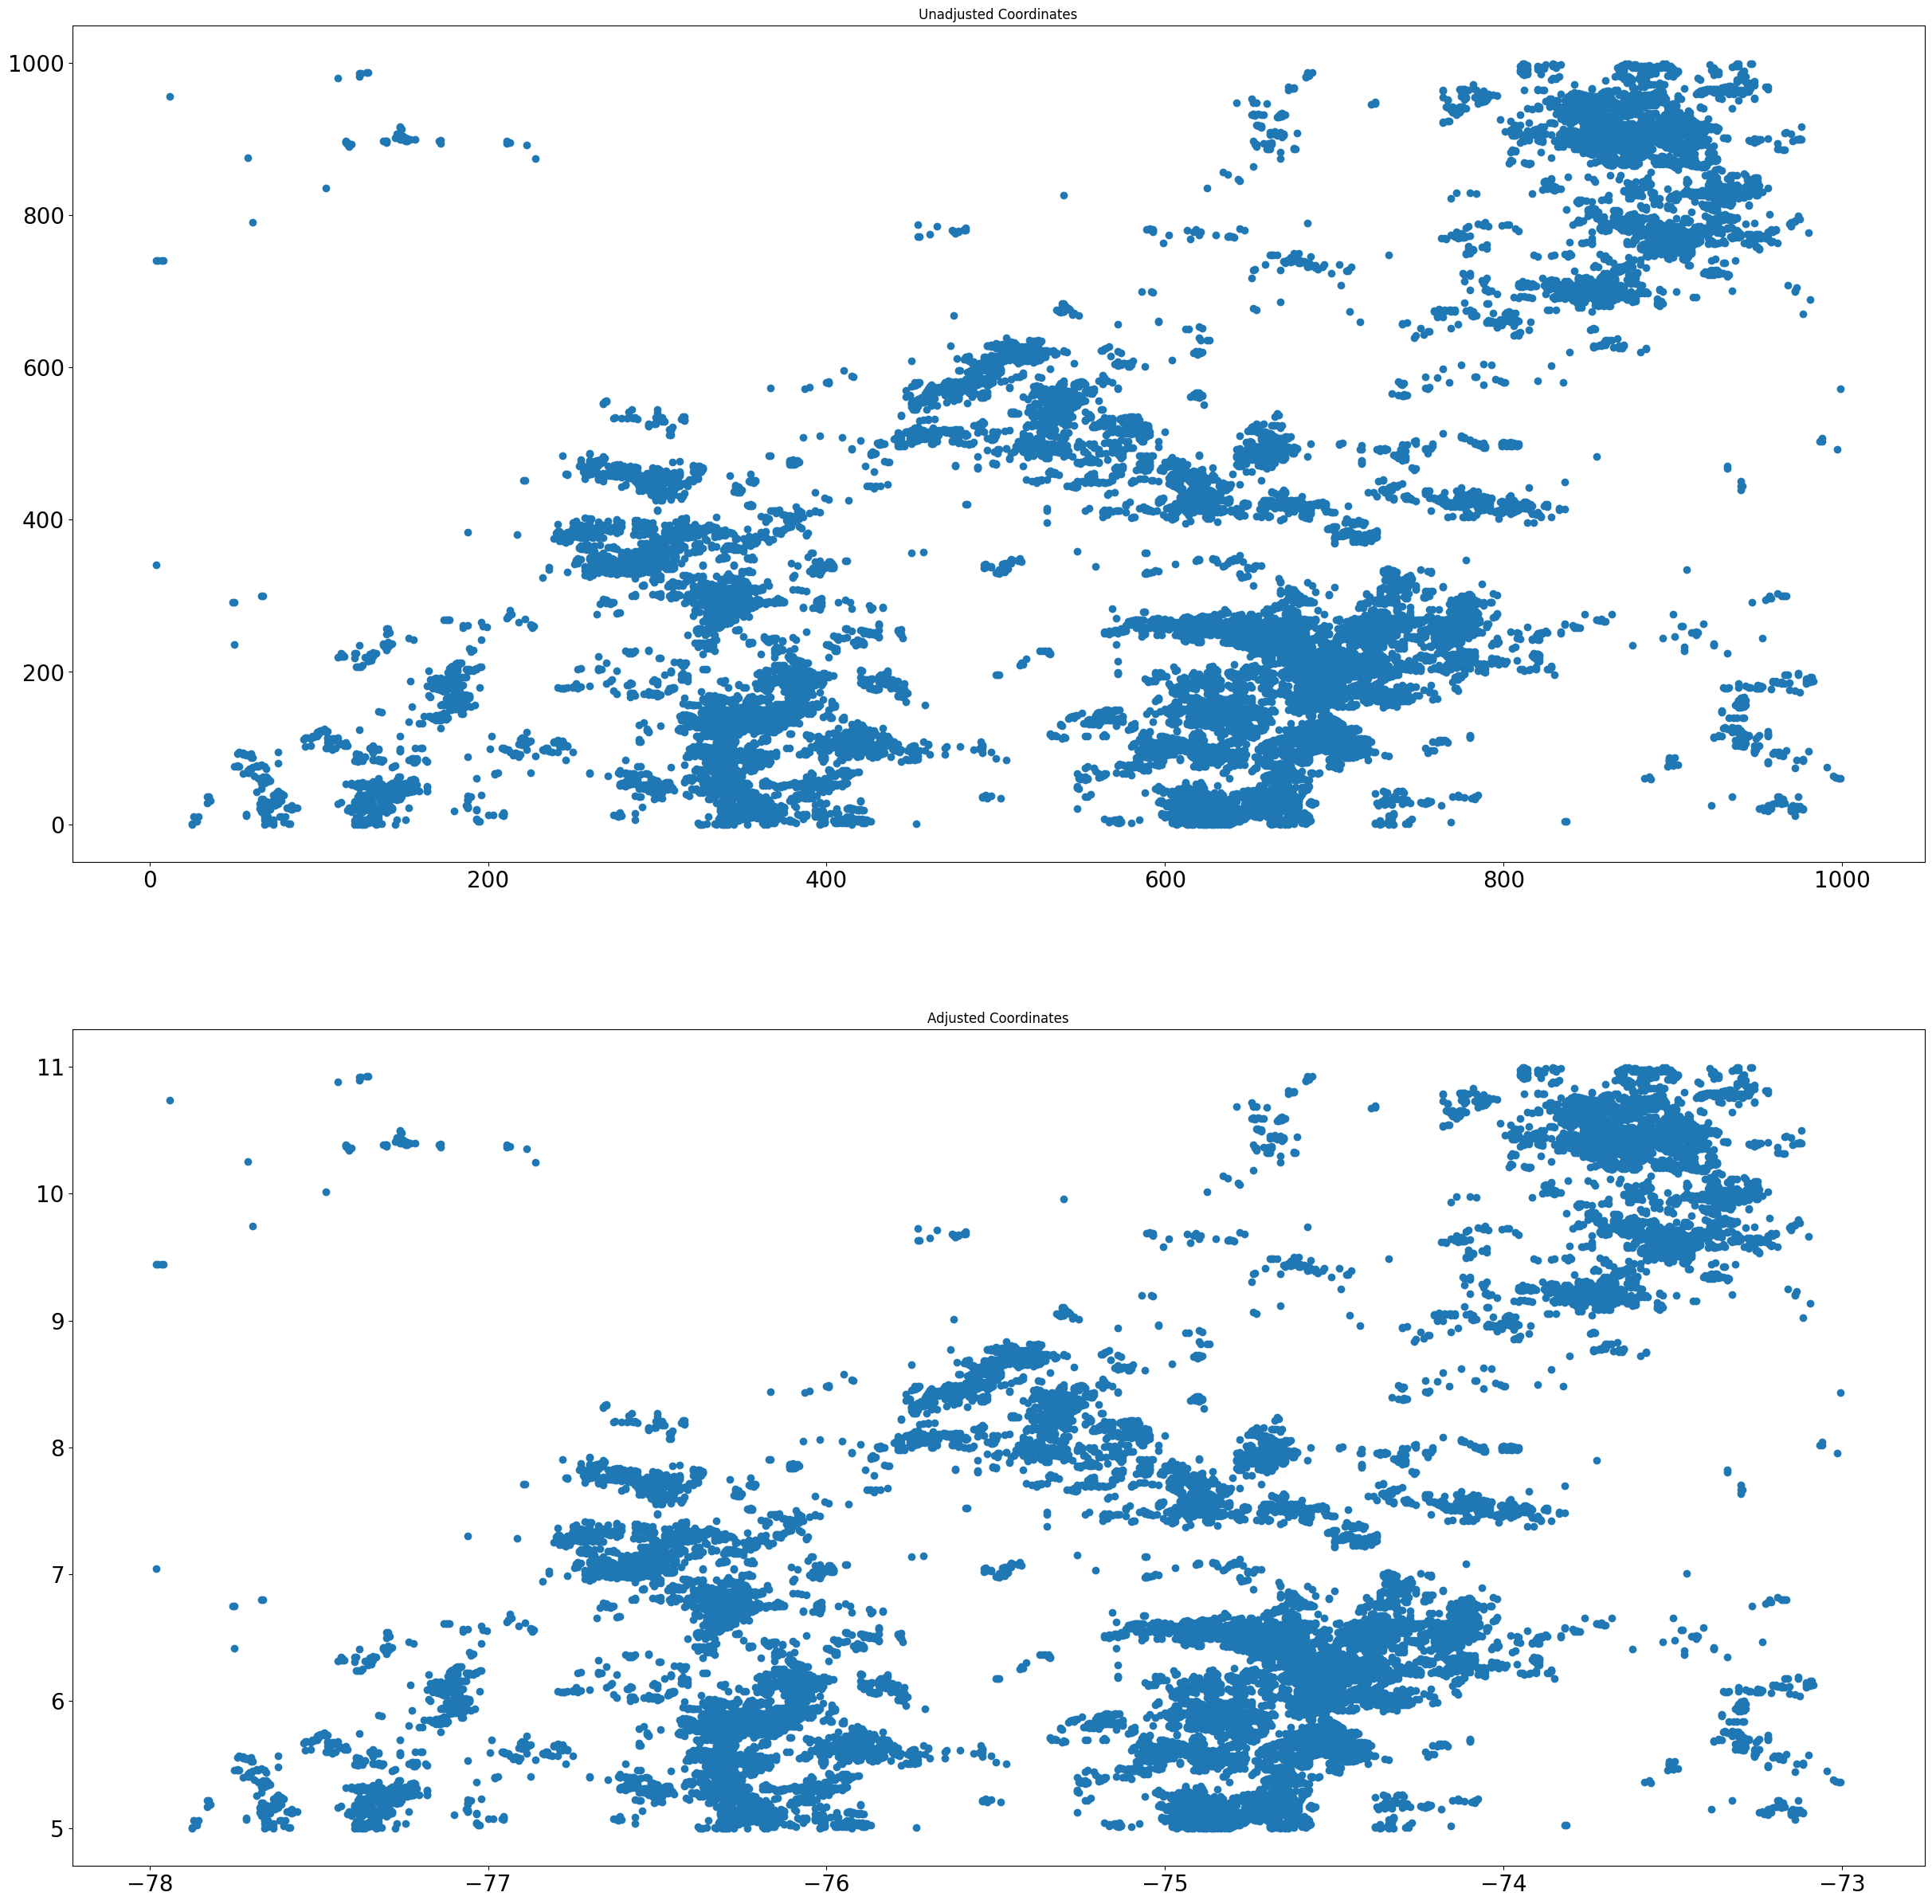

In [2]:
from Source.Fire_Map import Convert_to_Coordinates, Adjust_Axis_Ranges

# Convert noise map to lat/long coordinates
coordinates: list[tuple[int, int]] = Convert_to_Coordinates(noiseMapTruncated)
print(f"{len(coordinates):,} coordinates generated")

# Shift and scale coordinates
adjustedCoordinates: list[tuple[int, int]] = Adjust_Axis_Ranges(coordinates, (-78, -73), (5, 11), 1000, 1000)

# Create a matplot figure
figure, axis = plt.subplots(2, 1, figsize=(30, 30))
axis[0].scatter([i[0] for i in coordinates], [i[1] for i in coordinates])
axis[1].scatter([i[0] for i in adjustedCoordinates], [i[1] for i in adjustedCoordinates])
axis[0].set_title("Unadjusted Coordinates")
axis[0].tick_params(axis='both', labelsize=20)
axis[1].set_title("Adjusted Coordinates")
axis[1].tick_params(axis='both', labelsize=20)
plt.show()

# Identify Clusters (WIP)

*Todo*
- Determine a quality metric to select the best clustering algorithm
- Determine a good degree-to-meter conversion factor

DBSCAN Clusters: 49
OPTICS Clusters: 35
HDBSCAN Clusters: 17


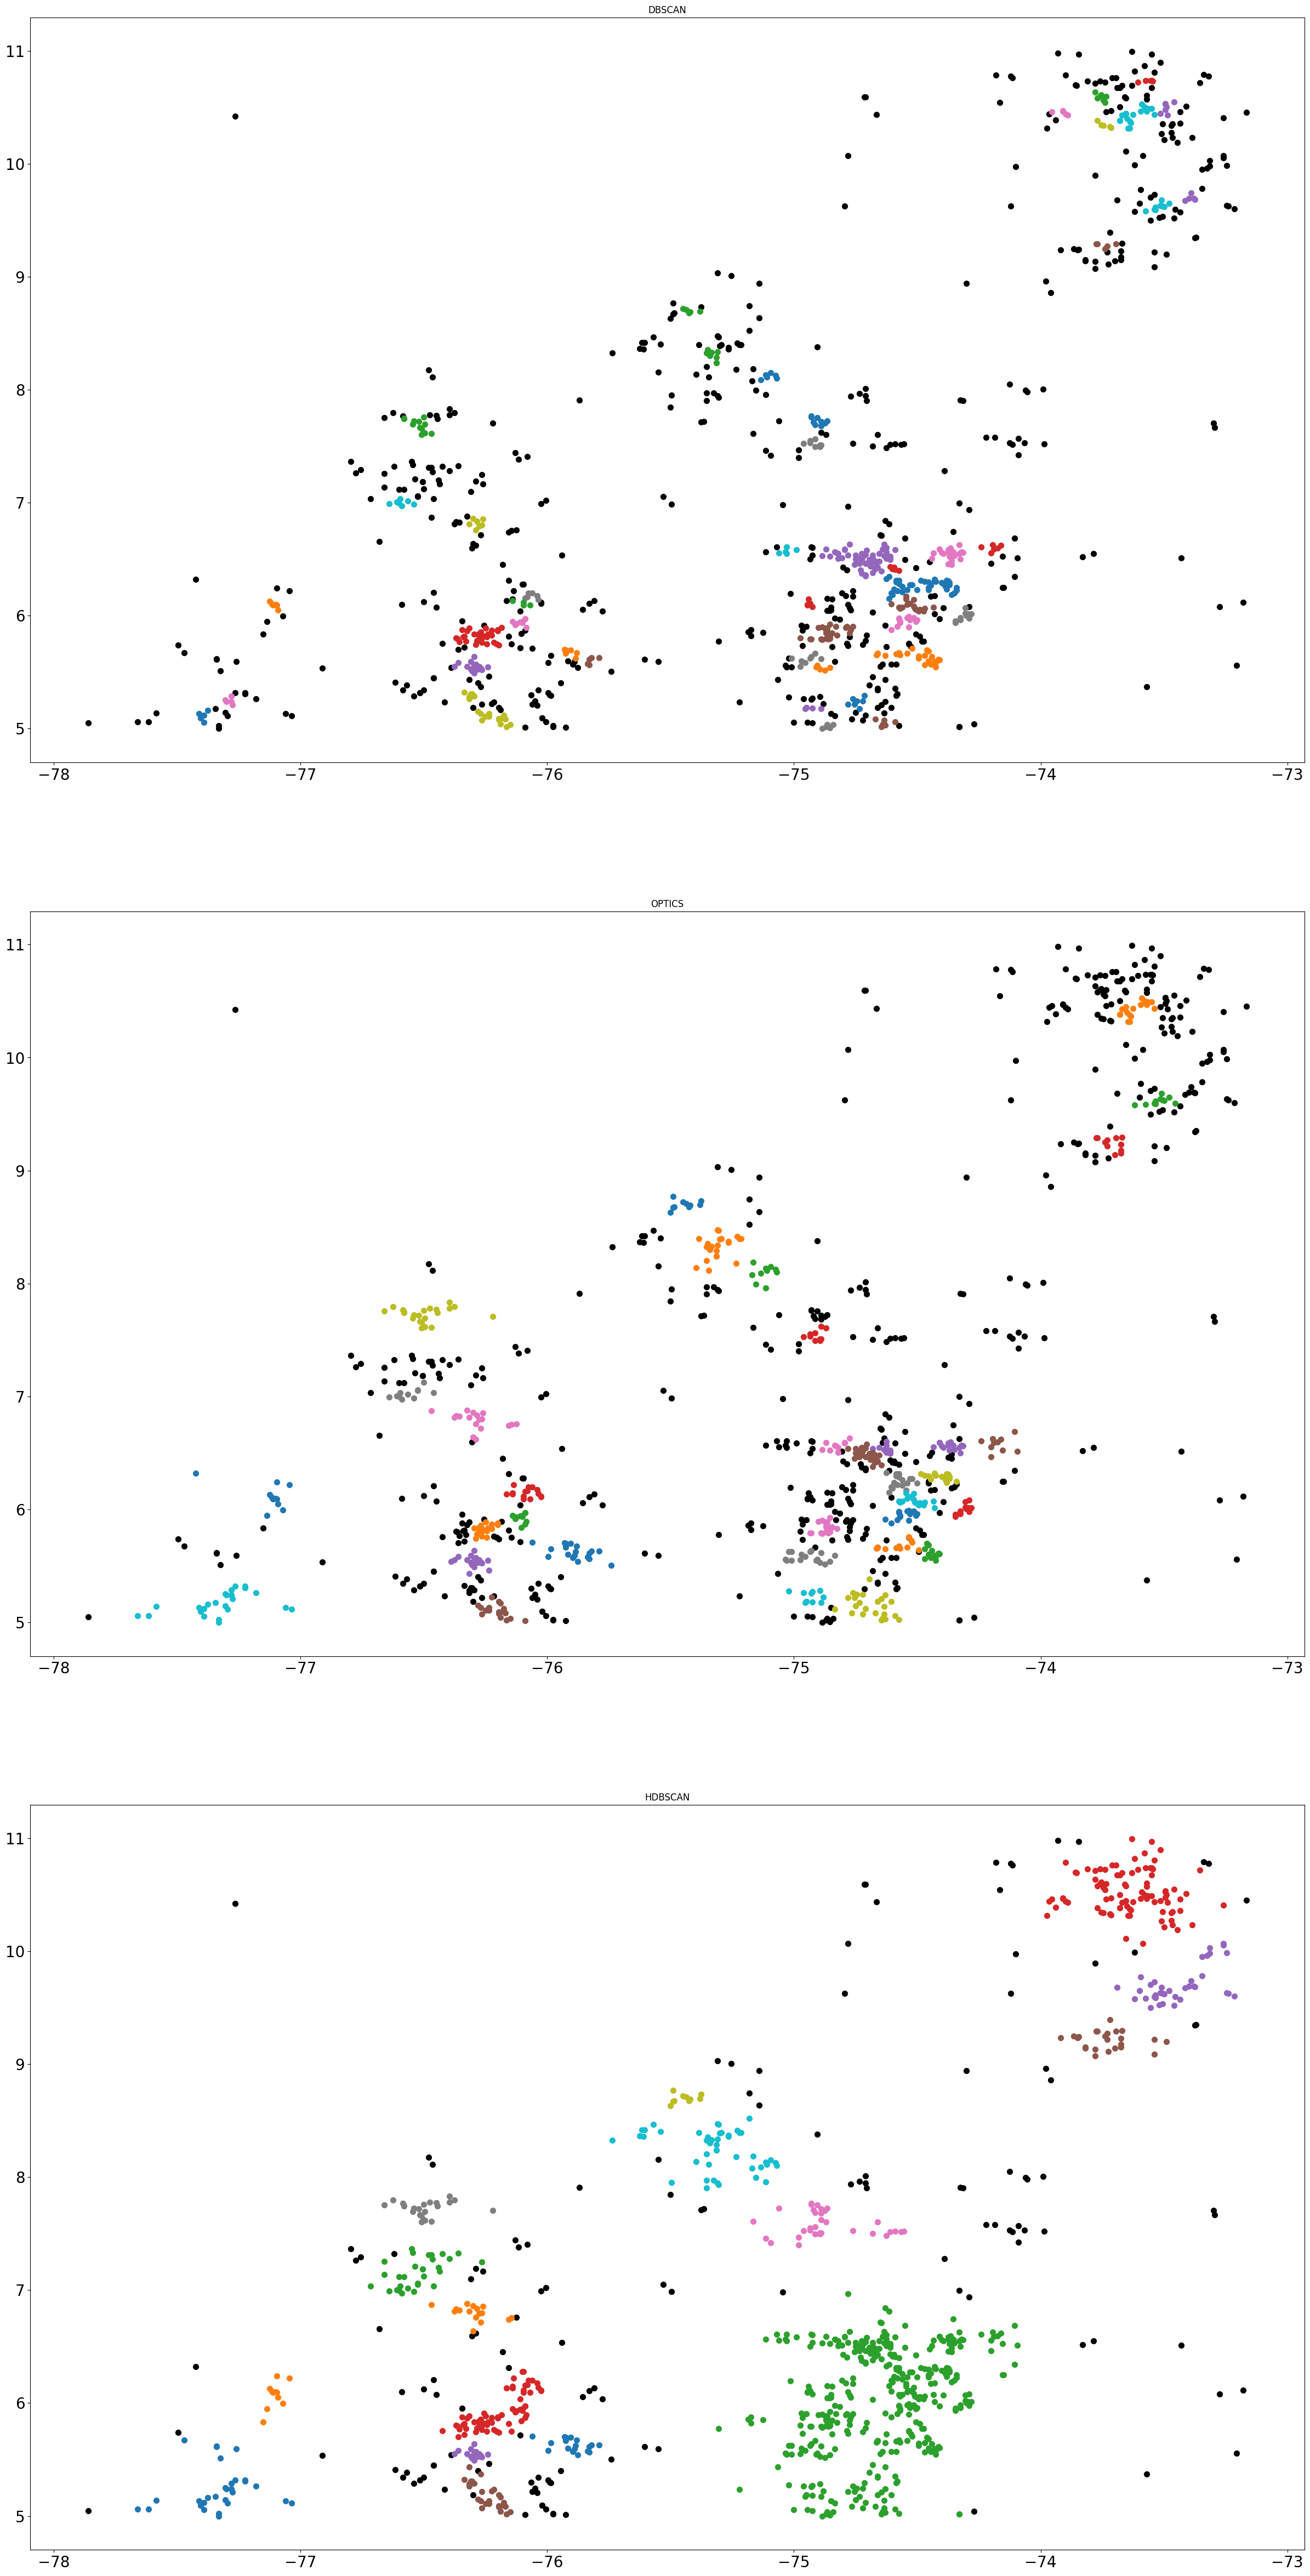

In [ ]:
from sklearn.cluster import DBSCAN, OPTICS, HDBSCAN
from numpy import array
from random import choices

def Build_Cluster_Dictionary(labels: list[int], coordinates: list[tuple[int, int]]) -> dict[int, list[tuple[int, int]]]:
    clusters: dict[int, list[tuple[int, int]]] = {}

    for index, clusterId in enumerate(labels):
        if clusterId in clusters:
            clusters[clusterId].append(coordinates[index])
        else:
            clusters[clusterId] = [coordinates[index]]

    return dict(sorted(clusters.items()))

# Feed coordinates into clustering algorithms
coordinateArray: ndarray = array(choices(adjustedCoordinates, k=1000))
algorithms: list = [
    DBSCAN(eps=0.05, min_samples=5),
    OPTICS(min_samples=5, min_cluster_size=10),
    HDBSCAN(min_samples=5, min_cluster_size=10)
]
[algorithm.fit(coordinateArray) for algorithm in algorithms]

# Prep for graphing
figure, axis = plt.subplots(
    len(algorithms), 1, figsize=(30, 20*len(algorithms))
)

# Calc Clusters
for algIndex, algorithm in enumerate(algorithms):
    clusters: dict[int, list[tuple[int, int]]] = Build_Cluster_Dictionary(
        array(algorithm.labels_).tolist(), 
        coordinateArray
    )
    print(f"{type(algorithm).__name__} Clusters: {len(clusters)}")

    # Label the graph
    axis[algIndex].set_title(f"{type(algorithm).__name__}")
    axis[algIndex].tick_params(axis='both', labelsize=20)

    # Plot clusters
    for key, value in clusters.items():
        axis[algIndex].scatter(
            [i[0] for i in value], [i[1] for i in value],
            s=50,
            c='black' if key == -1 else None
        )

# Plan Flight Path

# Train Neural Network